In [1]:
# RECURRENT GRAMMAR

Recurrent grammar is based on RecurrentGrammarV2 and RecurrentTranslator

### GENERATE RANDOM NETWORK

This grammar works with a set of production rules which generate a random network without specifying dimensions such as number of features for each layer.

The user must specify the desired number of layers in the network and the maximum of these layers which are recurrent.

Tree construction is sequential and follows these simple rules:
1. First node is always \<start\>
2. If previous node is \<start\>, sampled node can only be a recurrent layer (LSTM or GRU).
3. If previous node is recurrent, if maximum number of recurrent layers is not reached, sampled node can be a recurrent layer or a linear layer (with 2/3 probability of being recurrent), otherwise it can be only linear.
4. If previous node is linear, sampled node can be, with same probability, linear or dropout.
5. If previous node is dropout, sampled node can only be linear.
6. Last node is always \<end\>.

In [2]:
from cfg_nas.RecurrentGrammarV2 import RecurrentProductionRules

n_layers=5
max_recurrent_layers=2

production_rules = RecurrentProductionRules(n_layers=n_layers,
                                            max_recurrent_layers=max_recurrent_layers)

empty_tree = production_rules.grow_tree()

for node in empty_tree:
    print(node)

['<start>', None, None]
['LSTM', None, None]
['linear', None, None]
['dropout', None, None]
['linear', None, None]
['linear', None, None]
['<end>', None, None]


### FILL THE RANDOM NETWORK

Class __RecurrentGrammar__ does two things:
1. Generates an empty tree (as before)
2. Fill empty tree entries with reasonable values

It needs as parameters:
* Input dimension (number of features of input data)
* Output dimension (ex. 1 could be regression or binary classification)
* hidden_in (dimension of the recurrent layers)
* hidden_out (target dimension of linear layers)
* Number of layers
* Maximum number of recurrent layers

Setting layers parameters follow some rules:

__\<start\>__: this node is filled in the first position with the number of _features of input data_

__recurrent__: recurrent modules are set such that they take as input previous dimension, and transform always to __hidden\_in__. In first position we can find number of _output neurons_, second dimension is empty.

__linear__: linear modules number of features are set such that there is linear convergence from _hidden\_in_ to _hidden\_out_. Notice if previous node is recurrent, a __PickLast__ module is added which takes as linear input the last hidden state of recurrent network. In first position we can find number of _output neurons_ while second dimension is empty.

__dropout__: _dropout percentage_ is randomly sampled from a Beta with most of the probability mass concentrated in values lower than 0.5. This percenage can be found in first position while second position is empty

__\<end\>__: this node is the final dense layer, which outputs objective number of features. This quantity is found in first position while second is empty.

In [5]:
from cfg_nas.RecurrentGrammarV2 import RecurrentGrammar

recgram = RecurrentGrammar(input_dim=64,
                           output_dim=1,
                           hidden_in=256,
                           hidden_out=64,
                           n_layers=5,
                           max_recurrent_layers=2)

net = recgram.produceNetwork()
for layer in net:
    print(layer)

('<start>', 64, None)
('GRU', 256, None)
('linear', 208, None)
('dropout', 0.3165611404924837, None)
('linear', 112, None)
('dropout', 0.5997022262566577, None)
('<end>', 1, None)


### TRANSLATE THE MODEL INTO A TORCH WORKING MODEL

In otder to translate previous network to a working pytorch architecture, we need to pass it to TranslatedNetwork, which only needs the specification of the last activation and the type of all inner activations.

In [6]:
from cfg_nas.RecurrentTranslator import TranslatedNetwork
from torch import nn

model = TranslatedNetwork(network_tree=net,
                          default_activation=nn.ReLU(),
                          default_final_activation=nn.Sigmoid())

print(model.model)

Sequential(
  (0): GRU(64, 256, batch_first=True)
  (1): KeepHidden()
  (2): ReLU()
  (3): PickLast()
  (4): Linear(in_features=256, out_features=208, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3165611404924837, inplace=False)
  (7): Linear(in_features=208, out_features=112, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5997022262566577, inplace=False)
  (10): Linear(in_features=112, out_features=1, bias=True)
  (11): Sigmoid()
)


## WORKING EXAMPLE - SYNTHETIC DATA, 50 RANDOM NETWORKS EVALUATION

In [73]:
import torch
import torch.nn.functional as F

def generate_positive_definite_matrix(dim):
    # Generate a random symmetric matrix
    A = torch.randn(dim, dim)
    A = 0.5 * (A + A.t())

    # Ensure the matrix is positive definite
    A = A + dim * torch.eye(dim)

    return A

def multivariate_normal_samples(mean, cov_matrix, num_samples):
    # Ensure that the covariance matrix is positive definite
    cov_matrix = F.softplus(cov_matrix) + 1e-6 * torch.eye(cov_matrix.shape[0])

    # Cholesky decomposition
    L = torch.linalg.cholesky(cov_matrix, upper=False)

    # Generate samples
    standard_normal_samples = torch.randn(num_samples, cov_matrix.shape[0])
    samples = mean + torch.matmul(L, standard_normal_samples.t()).t()

    return samples

def ARProcess(size, length, features, coeff, mu=0):
    if isinstance(mu, (int, float)):
        mu = torch.ones((features)) + mu
    cov_matrix = generate_positive_definite_matrix(features)
    x_0 = multivariate_normal_samples(mu, cov_matrix, size)
    sequence = torch.empty((size, length, features))
    sequence[:,0,:] = x_0
    for i in range(1, length):
        x = multivariate_normal_samples(mu, cov_matrix, size)
        sequence[:,i,:] = sequence[:,i-1,:] + coeff*x
    return sequence

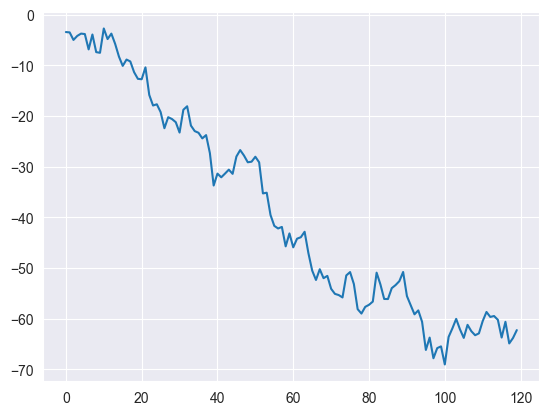

In [74]:
import matplotlib.pyplot as plt
import numpy as np
seq = ARProcess(size=3, length=120, features=30, coeff=-0.5, mu=0.05)
plt.plot(np.array(seq[0,:,0]))

Simulate we have 140 different investment portfolios, composed by good and bad ones

In [96]:
good_portf = ARProcess(size=70, length=12, features=20, coeff=0.5, mu=0.05)
bad_portf = ARProcess(size=70, length=12, features=20, coeff=-0.5, mu=0.05)

shuffled_index = torch.randperm(140)

labels = (shuffled_index < 70).unsqueeze(-1)*torch.ones((140,1))

data = torch.cat([good_portf, bad_portf], dim=0)
data = data[shuffled_index]

train_size = 100
train_x = data[:train_size]
train_y = labels[:train_size]
test_x = data[train_size:]
test_y = labels[train_size:]

In [97]:
recgram = RecurrentGrammar(input_dim=20,
                           output_dim=1,
                           hidden_in=128,
                           hidden_out=32,
                           n_layers=5,
                           max_recurrent_layers=2)

default_activation = nn.ReLU()
default_final_activation = nn.Sigmoid()

networks = []
for i in range(50):
    network_tree = recgram.produceNetwork()
    networks.append(TranslatedNetwork(network_tree=network_tree,
                                      default_activation=default_activation,
                                      default_final_activation=default_final_activation))

In [98]:
from cfg_nas.Trainer import AutoTrainer
from torch.optim import AdamW

auto_trainer = AutoTrainer(train_data=train_x,
                           train_labels=train_y,
                           test_data=test_x,
                           test_labels=test_y,
                           criterion=nn.BCELoss(reduction='sum'),
                           optimizer=AdamW,
                           num_epochs=100,
                           lr=0.01,
                           batch_size=64)

In [99]:
performance_list = {'avg_train_loss' : [],
                    'avg_test_loss' : [],
                   'test_accuracy' : []}

for network in networks:
    avg_test_loss, avg_train_loss, test_accuracy = auto_trainer.train(network)
    performance_list['avg_train_loss'].append(avg_train_loss)
    performance_list['avg_test_loss'].append(avg_test_loss)
    performance_list['test_accuracy'].append(test_accuracy)

100%|██████████| 100/100 [00:03<00:00, 25.71it/s]


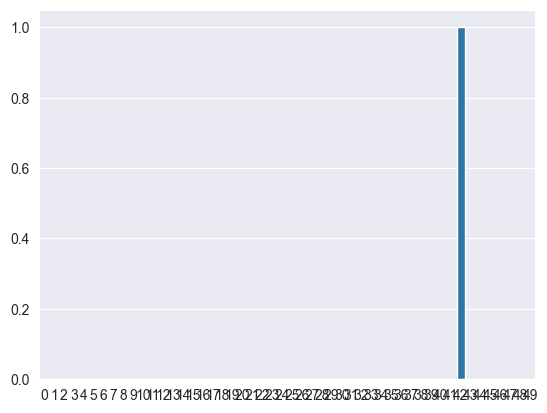

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(performance_list['avg_test_loss'])
plt.show()

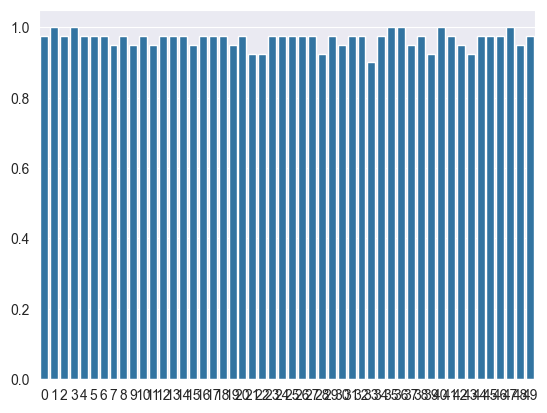

In [101]:
sns.barplot(performance_list['test_accuracy'])
plt.show()